In [1]:
import os
from os.path import join
from dotenv import load_dotenv

import numpy as np
import pandas as pd

import pyspark as ps
from pyspark.sql import SparkSession, DataFrame
import pyspark.sql.functions as F
from pyspark.sql.functions import col

import matplotlib as mlp
import matplotlib.pyplot as plt
import japanize_matplotlib

In [2]:
ps_conf = ps.SparkConf()\
            .set("spark.sql.sources.commitProtocolClass", "org.apache.spark.sql.execution.datasources.SQLHadoopMapReduceCommitProtocol")\
            .set("mapreduce.fileoutputcommitter.marksuccessfuljobs","false")\
            .set("spark.sql.shuffle.partitions",200)
            # '_started'と'_committed_'で始まるファイルを書き込まないように設定
            # '_SUCCESS'で始まるファイルを書き込まないように設定
            # パーティション数を増やす
spark = SparkSession.builder.config(conf=ps_conf).getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/11/11 11:46:42 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
def create_time_series_by1min(start_date:str, end_date:str):
    # 開始日時と終了日時を設定
    start_time = f'{start_date} 00:00:00'
    end_time   = f'{end_date} 23:59:00'
    # 1分単位の時間列を作成
    time_range = pd.date_range(start=start_time, end=end_time, freq='min')
    
    # DataFrameに変換
    pd_time = pd.DataFrame(time_range, columns=['datetime'])
    # display(df_time)
    
    spark = SparkSession.getActiveSession()
    return spark.createDataFrame(pd_time)

In [4]:
MITSUBISHI    = 'csv_data/beacon_for_mitsubishi.csv'
AKA_RENGA     = 'csv_data/beacon_aka_renga.csv'
df_csv = spark.read\
                .option('inferSchema', 'True')\
                .option('header', 'True')\
                .csv(MITSUBISHI)\
                .withColumn("datetime", F.date_trunc("minute", col("datetime")))\
                .groupBy("unit_id", "date", "datetime").count()\
                .select(["unit_id", "date", "datetime", "count"])
utid_list = sorted(df_csv.select("unit_id").drop_duplicates().rdd.flatMap(lambda x: x).collect())

pd_datetime = df_csv.select(F.max("date").alias("max"), F.min("date").alias("min")).toPandas()
start_date, end_date = pd_datetime["min"].tolist()[0].strftime('%Y-%m-%d'), pd_datetime["max"].tolist()[0].strftime('%Y-%m-%d')

df_1min = create_time_series_by1min(start_date, end_date)
for unit_id in utid_list:
    df_tmp  = df_csv.filter(col("unit_id") == unit_id)\
        		.withColumnRenamed("count", unit_id)\
				.select(["datetime", unit_id])
    df_1min = df_1min.join(df_tmp, on="datetime", how="left")
df_1min = df_1min.orderBy("datetime")

print("start_date:", start_date)
print("end_date:", end_date)
df_1min.show()

start_date: 2023-10-23
end_date: 2023-11-05


24/11/11 11:46:58 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


+-------------------+--------+--------+--------+--------+--------+--------+
|           datetime|1002A35C|1002A35D|1002A363|1002A36A|1002A36C|1002A370|
+-------------------+--------+--------+--------+--------+--------+--------+
|2023-10-23 00:00:00|    NULL|    NULL|    NULL|    NULL|    NULL|    NULL|
|2023-10-23 00:01:00|    NULL|    NULL|    NULL|    NULL|    NULL|    NULL|
|2023-10-23 00:02:00|    NULL|    NULL|    NULL|    NULL|    NULL|    NULL|
|2023-10-23 00:03:00|    NULL|    NULL|    NULL|    NULL|    NULL|    NULL|
|2023-10-23 00:04:00|    NULL|    NULL|    NULL|    NULL|    NULL|    NULL|
|2023-10-23 00:05:00|    NULL|    NULL|    NULL|    NULL|    NULL|    NULL|
|2023-10-23 00:06:00|    NULL|    NULL|    NULL|    NULL|    NULL|    NULL|
|2023-10-23 00:07:00|    NULL|    NULL|    NULL|    NULL|    NULL|    NULL|
|2023-10-23 00:08:00|    NULL|    NULL|    NULL|    NULL|    NULL|    NULL|
|2023-10-23 00:09:00|    NULL|    NULL|    NULL|    NULL|    NULL|    NULL|
|2023-10-23 

In [20]:
start_date = "2023-11-4 3:00"
end_date   = "2023-11-5 3:00"

unit_id list: ['1002A35C', '1002A35D', '1002A363', '1002A36A', '1002A36C', '1002A370']
nanの数： 300


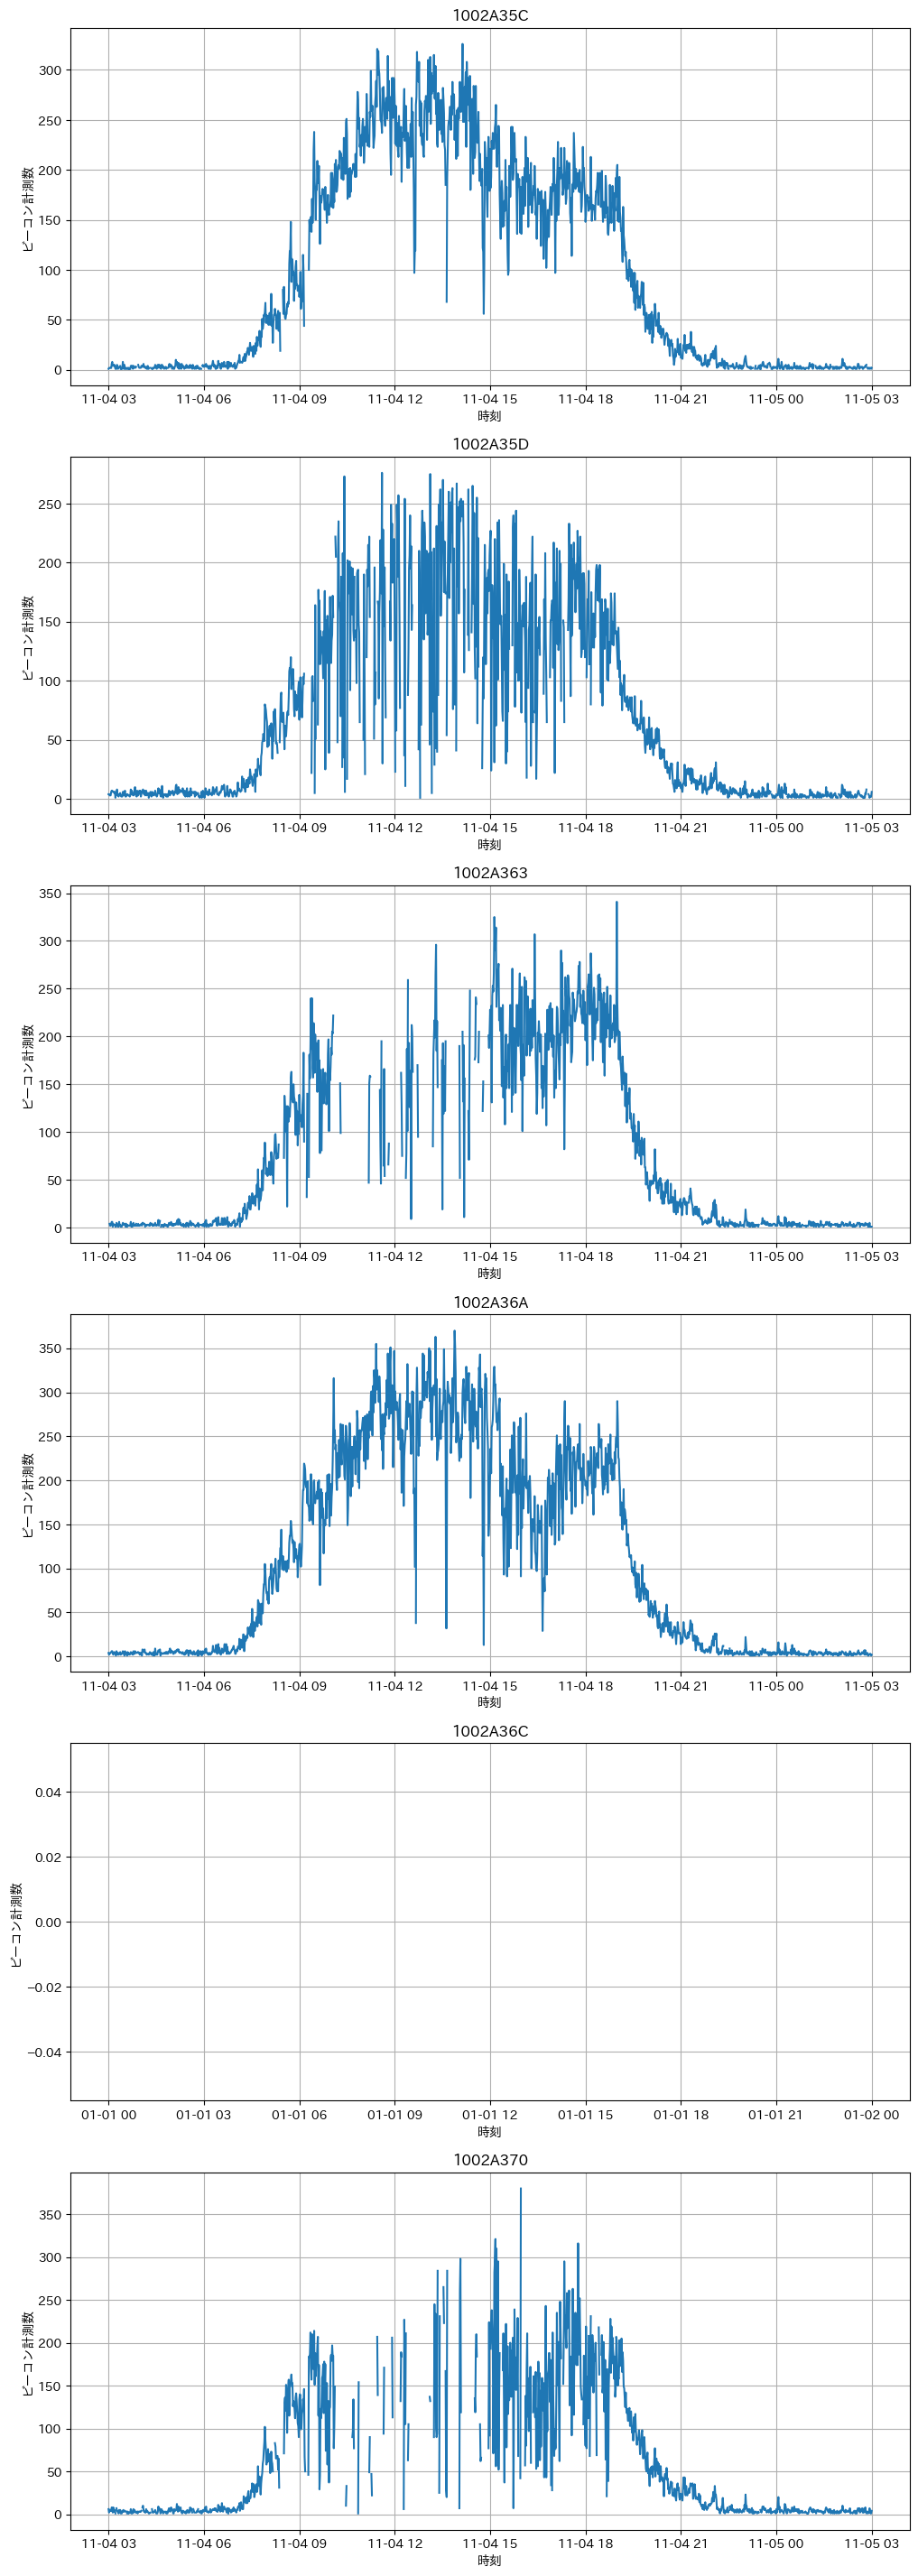

In [21]:
pd_counter = df_1min.filter((col("datetime") >= start_date) & (col("datetime") <= end_date)).toPandas()
date_list  = pd_counter["datetime"].tolist()

fig = plt.figure(figsize=(12, 36))
for idx, unit_id in enumerate(utid_list):
    axes = fig.add_subplot(len(utid_list), 1, idx + 1)
    
    count_list = pd_counter[unit_id].tolist()
    axes.plot(date_list, count_list, "-")
    axes.set_title(unit_id)
    axes.set_xlabel("時刻")
    axes.set_ylabel("ビーコン計測数")
    axes.grid(True)

print("unit_id list:", utid_list)
print("nanの数：", np.sum(np.isnan(count_list)))

unit_id list: ['1002A35C', '1002A35D', '1002A363', '1002A36A', '1002A36C', '1002A370']
nanの数： 0


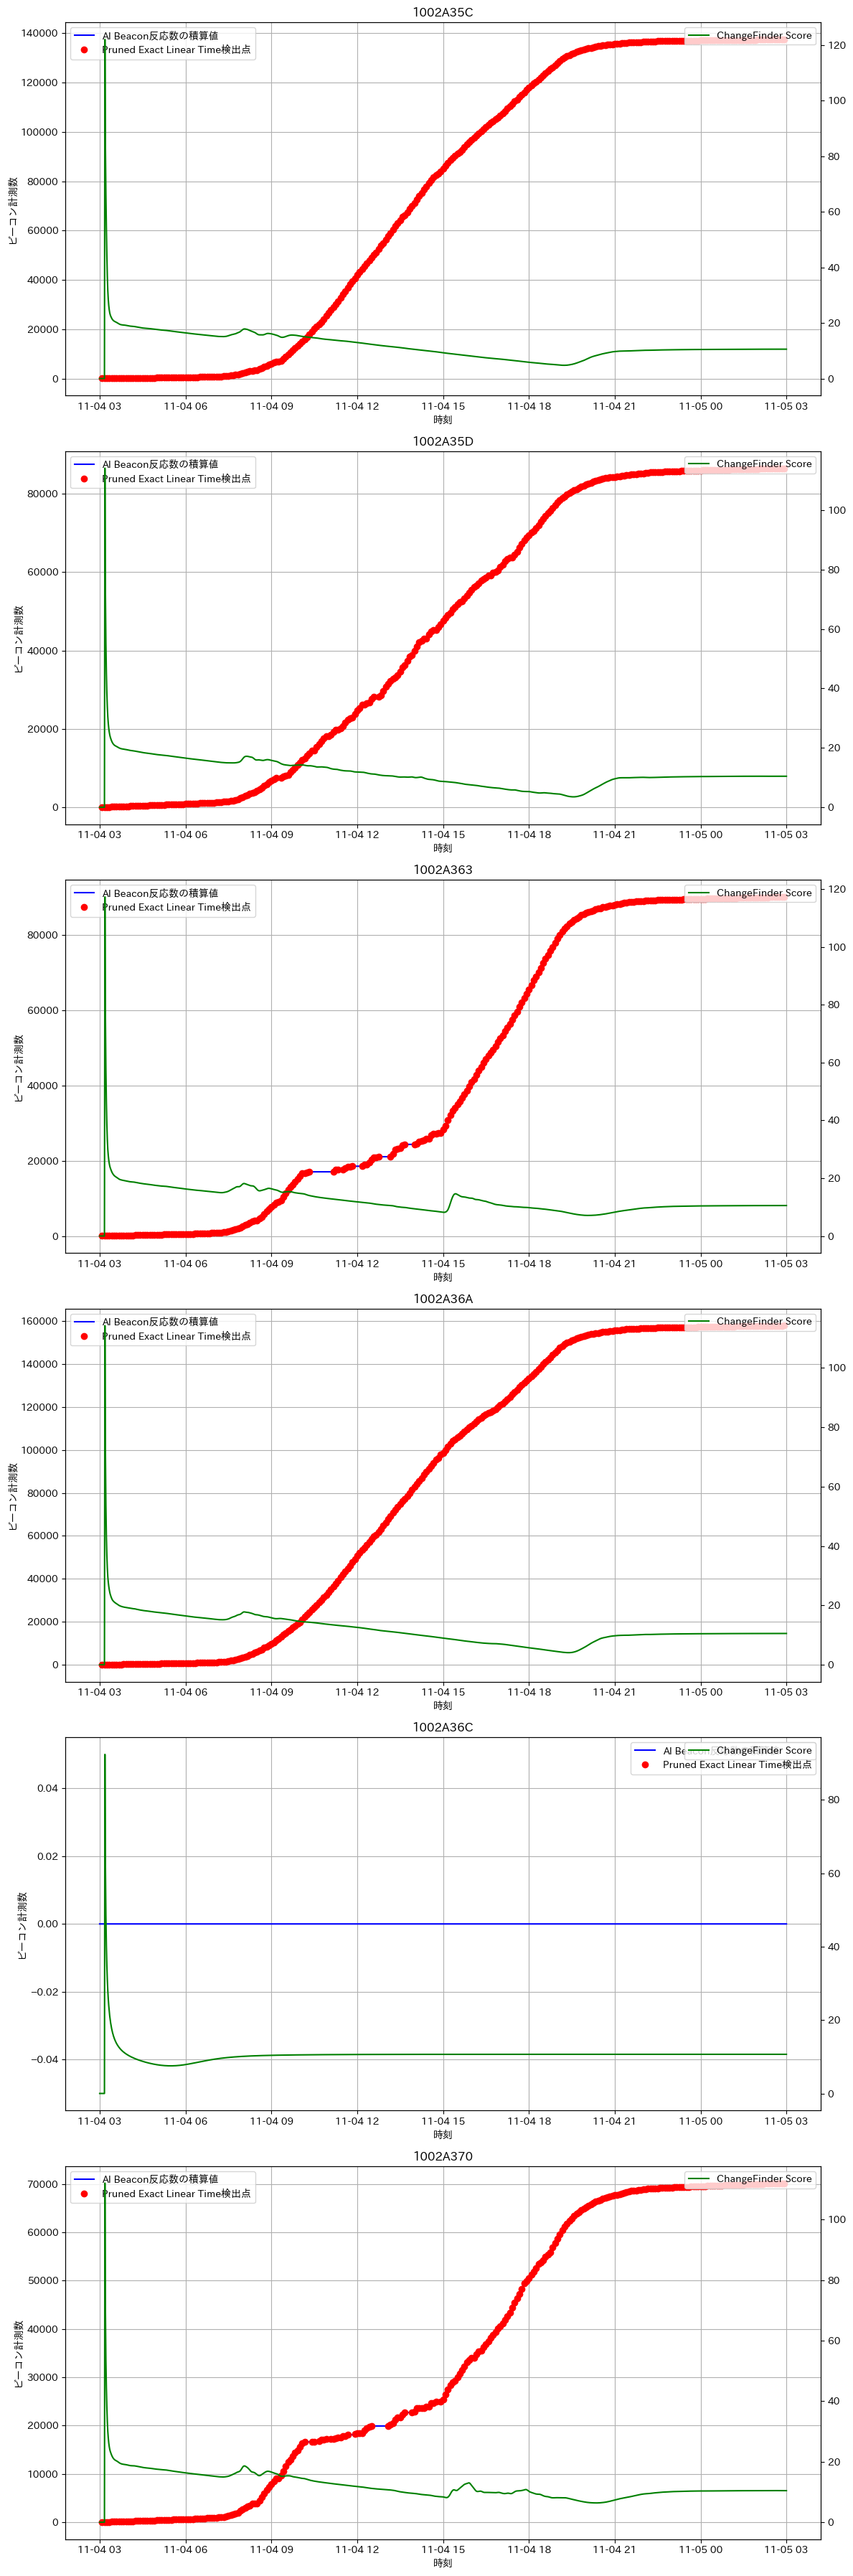

In [22]:
import changefinder
import ruptures as rpt

pd_counter = df_1min.filter((col("datetime") >= start_date) & (col("datetime") <= end_date)).toPandas()
date_list  = pd_counter["datetime"].tolist()

fig = plt.figure(figsize=(12, 36))
for idx, unit_id in enumerate(utid_list):
    axes = fig.add_subplot(len(utid_list), 1, idx + 1)
    
    w1 = 5
    
    count_list = pd_counter[unit_id].tolist()
    count_list = np.cumsum(np.nan_to_num(count_list))
    axes.plot(date_list, count_list, "-", label="AI Beacon反応数の積算値", color="blue")
    
    axes2  = axes.twinx()
    cf     = changefinder.ChangeFinder(r=0.01, order=1, smooth=7)
    scores = [cf.update(point) for point in count_list]
    axes2.plot(date_list, scores, "-", label="ChangeFinder Score", color="green")
    
    algo = rpt.Pelt(model='l2').fit(count_list)
    my_bkps = algo.predict(pen=0.1)
    algo_x = [date_list[idx]  for idx in my_bkps[:-1]]
    algo_y = [count_list[idx] for idx in my_bkps[:-1]]
    axes.plot(algo_x, algo_y, "o", label="Pruned Exact Linear Time検出点", color="red")
    
    axes.set_title(unit_id)
    axes.set_xlabel("時刻")
    axes.set_ylabel("ビーコン計測数")
    axes.grid(True)
    axes.legend()
    axes2.legend()

fig.tight_layout()
print("unit_id list:", utid_list)
print("nanの数：", np.sum(np.isnan(count_list)))

In [8]:
def moving_average(w1:int, x_list, y_list):
    if len(x_list) != len(y_list):
        raise ValueError()
    
    mov_ave = np.convolve(y_list, [1 / w1] * w1, mode='same')
    return x_list[w1:-w1], mov_ave[w1:-w1]

def diff_convolve(w1:int, x_list, y_list):
    if len(x_list) != len(y_list):
        raise ValueError()
    
    conv_list = np.convolve(y_list, [0.5, 0, -0.5], mode='full')
    tuple_xy  = moving_average(w1, x_list[1:-1], conv_list[2:-2])
    return tuple_xy

def arg_extremum(w1:int, α1:int, x_list, y_list):
    if len(x_list) != len(y_list):
        raise ValueError()
    
    x_list, y_list = diff_convolve(w1, x_list, y_list)
    x_list, y_list = diff_convolve(w1, x_list, y_list)
    
    convol_y  = np.diff(y_list)
    sign_list = np.sign(convol_y[:-1] * convol_y[1:])
    base_std  = np.std(y_list)
    
    sign_idx  = np.where(((sign_list == -1) & (convol_y[1:] > 0)) & (y_list[1:-1] < -α1 * base_std))[0]
    extre_min = 1 + sign_idx
    
    sign_idx  = np.where(((sign_list == -1) & (convol_y[1:] < 0)) & (y_list[1:-1] >  α1 * base_std))[0]
    extre_max = 1 + sign_idx
    
    return extre_min + 2 * (w1 + 1), extre_max + 2 * (w1 + 1)

unit_id list: ['1002A35C', '1002A35D', '1002A363', '1002A36A', '1002A36C', '1002A370']
nanの数： 300


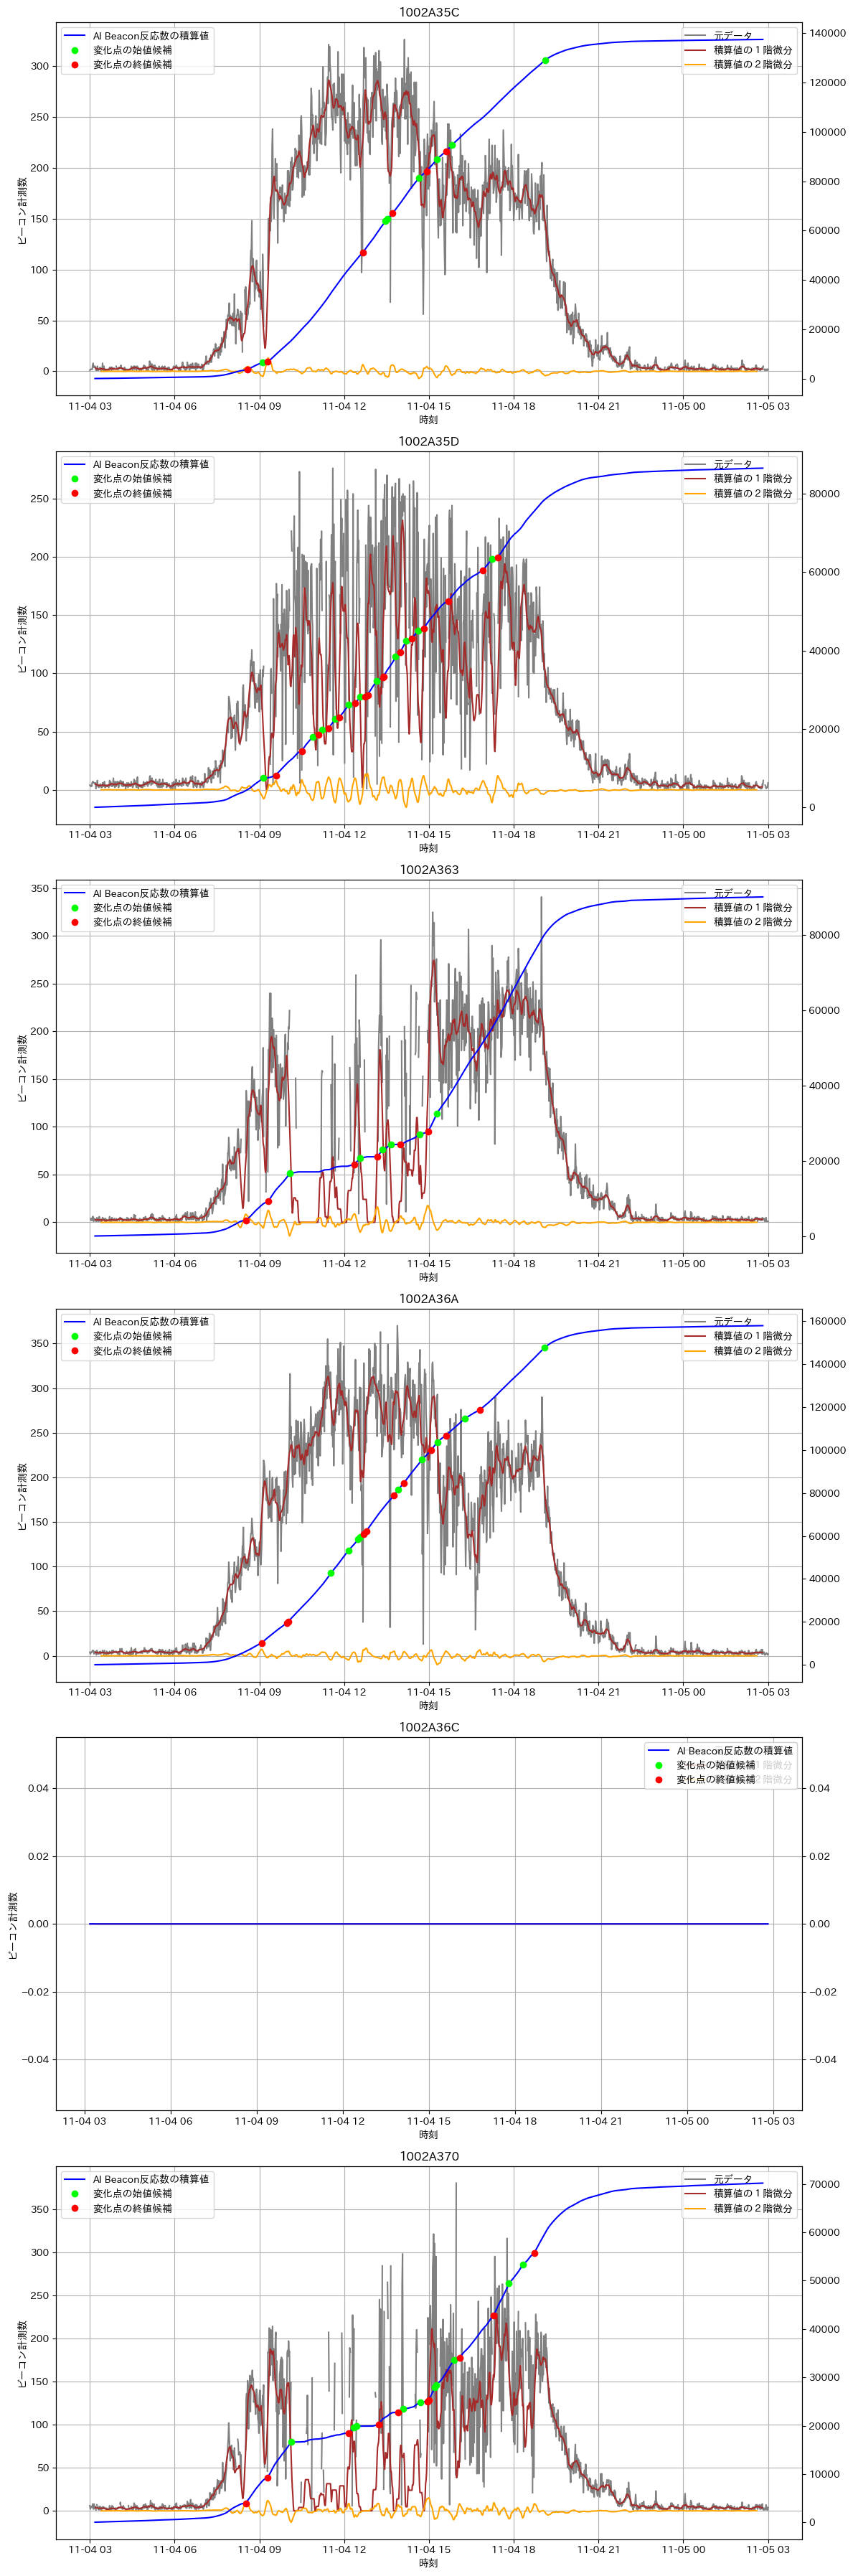

In [ ]:
pd_counter = df_1min.filter((col("datetime") >= start_date) & (col("datetime") <= end_date)).toPandas()
date_list  = pd_counter["datetime"].tolist()

fig = plt.figure(figsize=(12, 36))
for idx, unit_id in enumerate(utid_list):
    axes  = fig.add_subplot(len(utid_list), 1, idx + 1)
    axes2 = axes.twinx()
    
    w1 = 11
    α1 = 1.96
    
    # 標準正規分布の確立分布　数表
    # URL:https://kyozaikenkyu-statistics.blog.jp/%E6%A8%99%E6%BA%96%E6%AD%A3%E8%A6%8F%E5%88%86%E5%B8%83%E6%95%B0%E8%A1%A8.pdf
    # 主に以下の値が利用されると想定する
    # 優位水準8%   (片側4.0%) ・・・1.75
    # 優位水準5%   (片側2.5%) ・・・1.96
    # 優位水準3%   (片側1.5%) ・・・2.17
    # 優位水準1%   (片側0.5%) ・・・2.58
    # 優位水準0.5% (片側0.25%)・・・2.81
    
    count_list = pd_counter[unit_id].tolist()
    cumsum_list = np.cumsum(np.nan_to_num(count_list))
    d_list, c_list = moving_average(w1, date_list, cumsum_list)
    axes2.plot(d_list, c_list, "-", label="AI Beacon反応数の積算値", color="blue")
    
    axes.plot(date_list, count_list, "-", label="元データ",       color="gray")
    d_list, c_list = diff_convolve(w1, date_list, cumsum_list)
    axes.plot(d_list,    c_list,     "-", label="積算値の１階微分", color="brown")
    d_list, c_list = diff_convolve(w1, d_list, c_list)
    axes.plot(d_list,    c_list,     "-", label="積算値の２階微分", color="orange")
    
    extre_min, extre_max = arg_extremum(w1, α1, date_list, cumsum_list)
    extre_x = [date_list[idx]   for idx in extre_min]
    extre_y = [cumsum_list[idx] for idx in extre_min]
    axes2.plot(extre_x, extre_y, "o", label="変化点の始値候補", color="lime")
    extre_x = [date_list[idx]   for idx in extre_max]
    extre_y = [cumsum_list[idx] for idx in extre_max]
    axes2.plot(extre_x, extre_y, "o", label="変化点の終値候補", color="red")
    
    
    
    axes.set_title(unit_id)
    axes.set_xlabel("時刻")
    axes.set_ylabel("ビーコン計測数")
    axes.grid(True)
    axes.legend()
    axes2.legend()

fig.tight_layout()
print("unit_id list:", utid_list)
print("nanの数：", np.sum(np.isnan(count_list)))